# Load positions and analyze PCA for both replicates

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import prody as pdy
import MDAnalysis as mda
# from pyfamsa import Aligner, Sequence
from yaml import load, Loader
import pandas as pd
import seaborn as sns
import plotly.express as px
from Bio import AlignIO
from Bio.SeqUtils import seq1
from Bio.SeqIO import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sk_pca
from MDAnalysis.analysis import align
import pickle
import tqdm
plt.rcParams['svg.fonttype'] = 'none'

# Form-I + Form-I' PCA

In [41]:
with open("/home/kaustubh/MD_Simulations/simulations_data/pkls/Form_I_Ip_positions_array_rep1.pkl", 'rb') as f:
    positions_rep1 = pickle.load(f)

In [42]:
with open("/home/kaustubh/MD_Simulations/simulations_data/pkls/Form_I_Ip_positions_array_rep2.pkl", 'rb') as f:
    positions_rep2 = pickle.load(f)

In [43]:
with open("/home/kaustubh/MD_Simulations/simulations_data/pkls/Form_I_Ip_systems_rep2.pkl", 'rb') as f:
    systems_rep2 = pickle.load(f)

In [44]:
positions_rep1.shape, positions_rep2.shape

((52000, 1281), (52000, 1281))

In [45]:
sys_1 = [i + "_01" for i in systems_rep2]
sys_2 = [i + "_02" for i in systems_rep2]

In [46]:
positions = np.vstack((positions_rep1, positions_rep2))
# positions_DRbcS ) 
positions.shape

(104000, 1281)

In [47]:
pca = sk_pca(n_components=10, whiten=False)
scaler = StandardScaler(with_mean=True, with_std=False)

X = scaler.fit_transform(positions)
# Y = scaler.transform(positions_DRbcS)
X = pca.fit_transform(X)

# Y = pca.transform(Y)

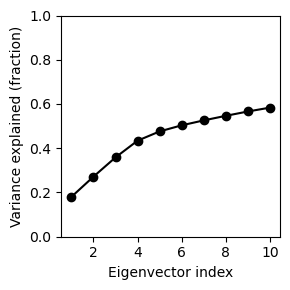

In [48]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3, 3)
ax.plot(np.arange(1, 11), pca.explained_variance_ratio_.cumsum(), marker='o', color='black')
ax.set_xlabel('Eigenvector index')
ax.set_ylabel('Variance explained (fraction)')
ax.set_ylim(0, 1)
fig.tight_layout()
# plt.savefig('./output/aligned_lsu_joint_pca_variance_ratio_explained_2_rep.svg')

In [49]:
pca.explained_variance_ratio_.cumsum()

array([0.17982274, 0.27130979, 0.35852214, 0.43417996, 0.47609402,
       0.50360877, 0.52595825, 0.54662197, 0.56619373, 0.58364346])

In [50]:
systems = sys_1 + sys_2

In [51]:
md_pca = pd.DataFrame.from_dict(dict(pca_x=X[:,0], pca_y=X[:, 1], pca_z=X[:, 2], label=systems))

In [52]:
md_pca['prot'] = md_pca.apply(lambda x: x['label'].split('_')[0], axis=1)
md_pca

,pca_x,pca_y,pca_z,label,prot
0,-2.426995,-6.990157,7.450163,1bwv_01,1bwv
1,1.157434,-6.780492,7.271456,1bwv_01,1bwv
2,1.460147,-8.887480,6.129014,1bwv_01,1bwv
3,-0.638197,-9.780756,5.924353,1bwv_01,1bwv
4,2.693843,-7.192798,7.092465,1bwv_01,1bwv
...,...,...,...,...,...
103995,26.482994,11.312499,-4.578920,ancip_02,ancip
103996,22.363661,11.316437,-3.365042,ancip_02,ancip
103997,23.397964,11.054671,-5.800741,ancip_02,ancip
103998,26.111140,15.176029,-2.713895,ancip_02,ancip


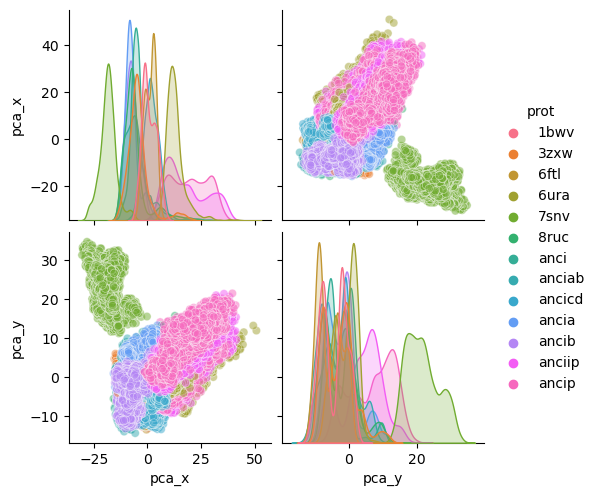

In [53]:
g = sns.pairplot(md_pca[['pca_x', 'pca_y', 'prot']], hue='prot', plot_kws={"alpha":0.5})
# plt.savefig("./output/aligned_lsu_normalized_pca_2_rep.svg")
# plt.savefig("./output/aligned_lsu_normalized_pca_2_rep.png", dpi=300, bbox_inches='tight')


In [54]:
md_pca['subunit'] = md_pca['prot'].isin(['1bwv', '3zxw', '6ftl', '7snv', '8ruc', 'anci', 'anciab', 'ancicd', 'ancia', 'ancib'])

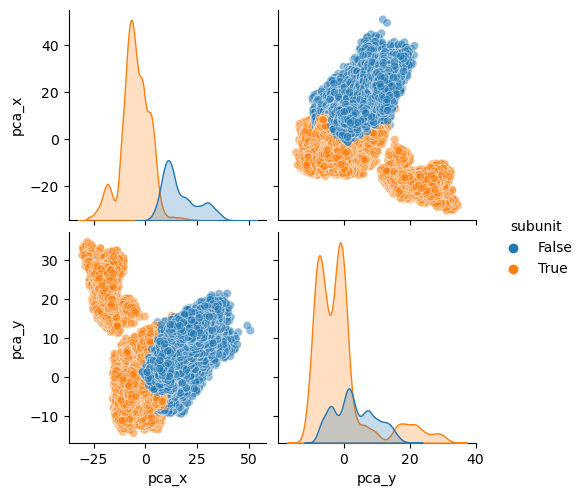

In [55]:
g = sns.pairplot(md_pca[['pca_x', 'pca_y', 'subunit']], hue='subunit', plot_kws={"alpha":0.5})
# plt.savefig("./output/aligned_lsu_normalized_pca_subunit_presence_absence_2_rep.svg")
# plt.savefig("./output/aligned_lsu_normalized_pca_subunit_presence_absence_2_rep.png", dpi=300, bbox_inches='tight')

In [ ]:
pc1_formI = md_pca[md_pca['subunit']]['pca_x']
pc1_formIp = md_pca[~md_pca['subunit']]['pca_x']

In [49]:
## Assessing the normality of the PC1 data

from scipy.stats import normaltest

stat1, p_value1 = normaltest(pc1_formI)
stat2, p_value2 = normaltest(pc1_formIp)

print("p_val1: ", p_value1)
print("p_val2: ", p_value2)

p_val1:  0.0
p_val2:  0.0


In [52]:
## Applying a Mann-Whitney U test

from scipy.stats import ttest_ind, mannwhitneyu

t_stat, p_val_t = ttest_ind(pc1_formI, pc1_formIp)
u_stat, p_val_u = mannwhitneyu(pc1_formI, pc1_formIp)
print(t_stat, p_val_t, u_stat, p_val_u)

-397.13682172908005 0.0 20929562.0 0.0


# Form-I + Form-I' + Anc-I_wo_RbcS -- PCA

In [56]:
with open("/home/kaustubh/MD_Simulations/simulations_data/pkls/Form_I_Ip_anci-wo-ssu_positions_array_rep1.pkl", 'rb') as f:
    positions_anciwossu_rep1 = pickle.load(f)

In [57]:
with open("/home/kaustubh/MD_Simulations/simulations_data/pkls/Form_I_Ip_anci-wo-ssu_positions_array_rep2.pkl", 'rb') as f:
    positions_anciwossu_rep2 = pickle.load(f)

In [58]:
with open("/home/kaustubh/MD_Simulations/simulations_data/pkls/Form_I_Ip_anci-wo-ssu_systems_rep1.pkl", 'rb') as f:
    systems_anciwossu_rep1 = pickle.load(f)

with open("/home/kaustubh/MD_Simulations/simulations_data/pkls/Form_I_Ip_anci-wo-ssu_systems_rep2.pkl", 'rb') as f:
    systems_anciwossu_rep2 = pickle.load(f)

In [59]:
sys_anciwossu_1 = [i + "_01" for i in systems_anciwossu_rep1]
sys_anciwossu_2 = [i + "_02" for i in systems_anciwossu_rep2]

In [60]:
positions_anciwossu = np.vstack((positions_anciwossu_rep1, positions_anciwossu_rep2))
positions_anciwossu.shape

(112000, 1281)

In [61]:
pca = sk_pca(n_components=10, whiten=False)
scaler = StandardScaler(with_mean=True, with_std=False)

X = scaler.fit_transform(positions)
Y = scaler.transform(positions_anciwossu)

X = pca.fit_transform(X)
Y = pca.transform(Y)

In [62]:
X.shape, Y.shape

((104000, 10), (112000, 10))

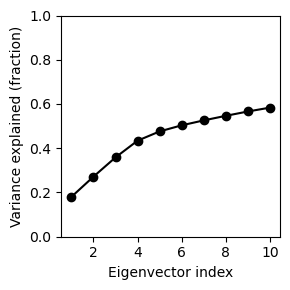

In [63]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3, 3)
ax.plot(np.arange(1, 11), pca.explained_variance_ratio_.cumsum(), marker='o', color='black')
ax.set_xlabel('Eigenvector index')
ax.set_ylabel('Variance explained (fraction)')
ax.set_ylim(0, 1)
fig.tight_layout()
plt.savefig('./output/aligned_lsu_joint_pca_variance_ratio_explained_Form_I_Ip_anciwossu_2_rep.svg')

In [64]:
pca.explained_variance_ratio_.cumsum()

array([0.17982274, 0.27130979, 0.35852214, 0.43417996, 0.47609402,
       0.50360877, 0.52595825, 0.54662199, 0.56619375, 0.58364351])

In [65]:
sys_anciwossu = sys_anciwossu_1 + sys_anciwossu_1

In [66]:
md_pca_anciwossu = pd.DataFrame.from_dict(dict(pca_x=Y[:,0], pca_y=Y[:, 1], pca_z=Y[:, 2], label=sys_anciwossu))

In [67]:
md_pca_anciwossu['prot'] = md_pca_anciwossu.apply(lambda x: x['label'].split('_')[0], axis=1)
md_pca_anciwossu

,pca_x,pca_y,pca_z,label,prot
0,-2.165828,-12.877399,21.718299,1bwv_01,1bwv
1,1.437054,-12.626834,21.545412,1bwv_01,1bwv
2,1.666807,-14.880114,20.456459,1bwv_01,1bwv
3,-0.482801,-15.667771,20.188442,1bwv_01,1bwv
4,2.923388,-13.122591,21.440025,1bwv_01,1bwv
...,...,...,...,...,...
111995,5.645118,-11.509676,17.065541,anci-wo-ssu_01,anci-wo-ssu
111996,11.180559,-6.354842,18.766097,anci-wo-ssu_01,anci-wo-ssu
111997,2.227788,-11.625090,16.759527,anci-wo-ssu_01,anci-wo-ssu
111998,10.085483,-9.615152,18.266100,anci-wo-ssu_01,anci-wo-ssu


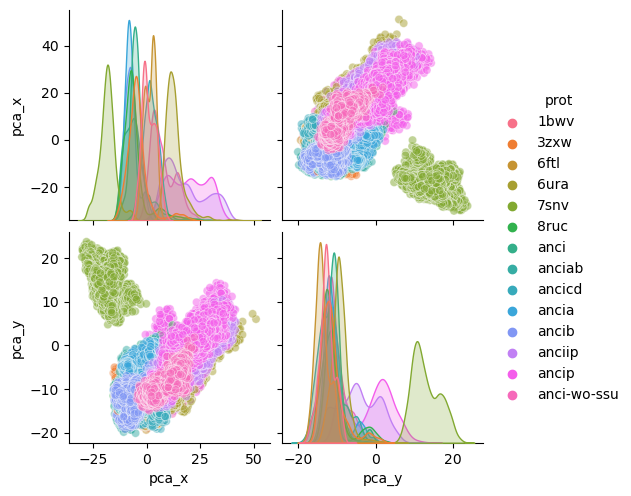

In [68]:
g = sns.pairplot(md_pca_anciwossu[['pca_x', 'pca_y', 'prot']], hue='prot', plot_kws={"alpha":0.5})
# plt.savefig("./output/aligned_lsu_normalized_pca_2_rep.svg")
# plt.savefig("./output/aligned_lsu_normalized_pca_2_rep.png", dpi=300, bbox_inches='tight')


In [69]:
dict_labels = {
    '1bwv': "Form-I", 
    '3zxw': "Form-I", 
    '6ftl': "Form-I", 
    '6ura': "Form-I'", 
    '7snv': "Form-I", 
    '8ruc': "Form-I", 
    '9rub': "Form-II", 
    'anci': "Form-I",
    'anciab': "Form-I", 
    'ancicd': "Form-I", 
    'ancia': "Form-I", 
    'ancib': "Form-I", 
    'anciip': "Form-I'", 
    'ancip': "Form-I'",
    'anci-wo-ssu': "Anc-I without RbcS"
}

md_pca_anciwossu['sp_label'] = md_pca_anciwossu.apply(lambda x: dict_labels[x['prot']], axis=1)
md_pca_anciwossu

,pca_x,pca_y,pca_z,label,prot,sp_label
0,-2.165828,-12.877399,21.718299,1bwv_01,1bwv,Form-I
1,1.437054,-12.626834,21.545412,1bwv_01,1bwv,Form-I
2,1.666807,-14.880114,20.456459,1bwv_01,1bwv,Form-I
3,-0.482801,-15.667771,20.188442,1bwv_01,1bwv,Form-I
4,2.923388,-13.122591,21.440025,1bwv_01,1bwv,Form-I
...,...,...,...,...,...,...
111995,5.645118,-11.509676,17.065541,anci-wo-ssu_01,anci-wo-ssu,Anc-I without RbcS
111996,11.180559,-6.354842,18.766097,anci-wo-ssu_01,anci-wo-ssu,Anc-I without RbcS
111997,2.227788,-11.625090,16.759527,anci-wo-ssu_01,anci-wo-ssu,Anc-I without RbcS
111998,10.085483,-9.615152,18.266100,anci-wo-ssu_01,anci-wo-ssu,Anc-I without RbcS


In [50]:
md_pca_anciwossu['subunit'] = md_pca_anciwossu['prot'].isin(['1bwv', '3zxw', '6ftl', '7snv', '8ruc', 'anci', 'anciab', 'ancicd', 'ancia', 'ancib'])

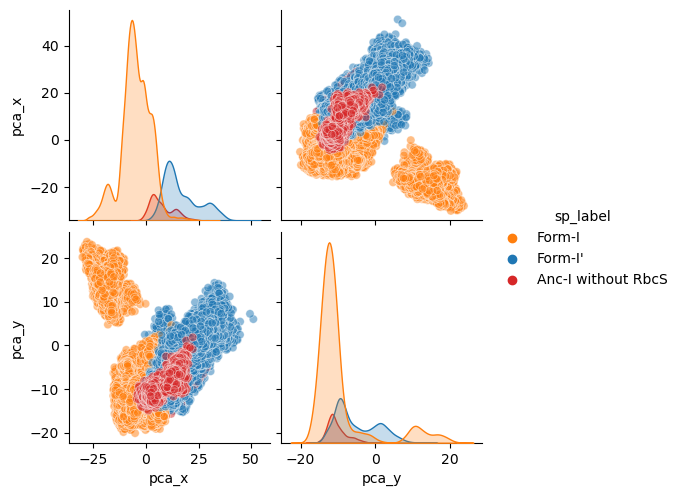

In [71]:
g = sns.pairplot(md_pca_anciwossu[['pca_x', 'pca_y', 'sp_label']], hue='sp_label', plot_kws={"alpha":0.5}, palette=['#ff7f0e', '#1f77b4', '#d62728'])
plt.savefig("./output/aligned_lsu_normalized_pca_Form_I_Ip_anciwossu_2_rep.svg")
plt.savefig("./output/aligned_lsu_normalized_pca_Form_I_Ip_anciwossu_2_rep.png", dpi=300, bbox_inches='tight')

In [59]:
pc1_formI = md_pca_anciwossu[md_pca_anciwossu['sp_label'] == "Form-I"]['pca_x']
pc1_formIp = md_pca_anciwossu[md_pca_anciwossu['sp_label'] == "Form-I'"]['pca_x']
pc1_anci_wo_ssu = md_pca_anciwossu[md_pca_anciwossu['sp_label'] == "Anc-I without RbcS"]['pca_x']

# Form-I + Form-I' + 9RUB -- PCA

In [13]:
with open("/home/kaustubh/MD_Simulations/simulations_data/pkls/Form_I_Ip_9rub_positions_array_rep1.pkl", 'rb') as f:
    positions_rep1 = pickle.load(f)

In [14]:
with open("/home/kaustubh/MD_Simulations/simulations_data/pkls/Form_I_Ip_9rub_positions_array_rep2.pkl", 'rb') as f:
    positions_rep2 = pickle.load(f)

In [15]:
with open("/home/kaustubh/MD_Simulations/simulations_data/pkls/Form_I_Ip_9rub_systems_rep1.pkl", 'rb') as f:
    systems_rep1 = pickle.load(f)

with open("/home/kaustubh/MD_Simulations/simulations_data/pkls/Form_I_Ip_9rub_systems_rep2.pkl", 'rb') as f:
    systems_rep2 = pickle.load(f)

In [16]:
positions_rep1.shape, positions_rep2.shape

((53000, 1239), (53000, 1239))

In [17]:
sys_1 = [i + "_01" for i in systems_rep1]
sys_2 = [i + "_02" for i in systems_rep2]

In [18]:
positions = np.vstack((positions_rep1, positions_rep2))
# positions_DRbcS ) 
positions.shape

(106000, 1239)

In [19]:
pca = sk_pca(n_components=10, whiten=False)
scaler = StandardScaler(with_mean=True, with_std=False)

X = scaler.fit_transform(positions)
X = pca.fit_transform(X)

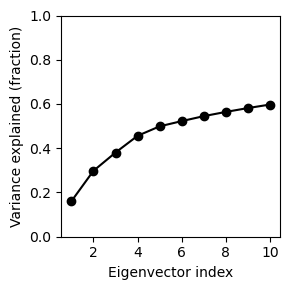

In [32]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3, 3)
ax.plot(np.arange(1, 11), pca.explained_variance_ratio_.cumsum(), marker='o', color='black')
ax.set_xlabel('Eigenvector index')
ax.set_ylabel('Variance explained (fraction)')
ax.set_ylim(0, 1)
fig.tight_layout()
plt.savefig('./output/aligned_lsu_joint_pca_variance_ratio_explained_Form_I_Ip_II_2_rep.svg')

In [21]:
pca.explained_variance_ratio_.cumsum()

array([0.16009908, 0.29774513, 0.38038294, 0.45618513, 0.49900384,
       0.52262382, 0.54513275, 0.56421397, 0.58160927, 0.59753279])

In [22]:
systems = sys_1 + sys_2

In [23]:
md_pca = pd.DataFrame.from_dict(dict(pca_x=X[:,0], pca_y=X[:, 1], pca_z=X[:, 2], label=systems))

In [24]:
md_pca['prot'] = md_pca.apply(lambda x: x['label'].split('_')[0], axis=1)
md_pca

,pca_x,pca_y,pca_z,label,prot
0,-0.461977,2.989197,-9.095580,1bwv_01,1bwv
1,-2.003650,0.522365,-8.810893,1bwv_01,1bwv
2,0.103303,-1.277865,-8.685555,1bwv_01,1bwv
3,-4.165987,-2.034175,-8.569252,1bwv_01,1bwv
4,-0.815955,-0.995481,-8.877959,1bwv_01,1bwv
...,...,...,...,...,...
105995,2.229270,-12.779128,8.893236,ancip_02,ancip
105996,7.914991,-13.218483,8.340122,ancip_02,ancip
105997,4.229705,-16.710942,10.192351,ancip_02,ancip
105998,5.649094,-12.190295,8.689073,ancip_02,ancip


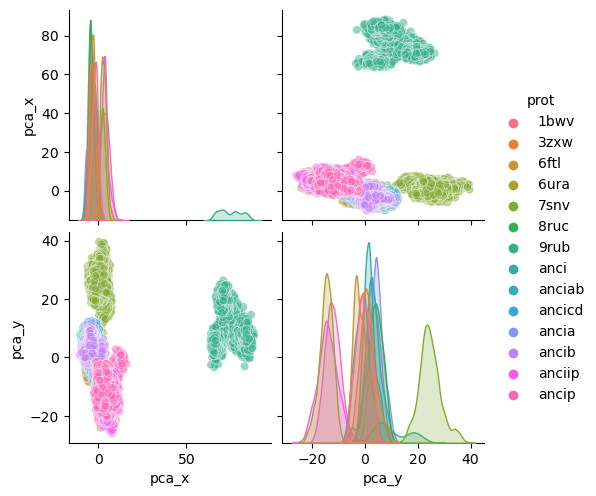

In [25]:
g = sns.pairplot(md_pca[['pca_x', 'pca_y', 'prot']], hue='prot', plot_kws={"alpha":0.5})
# plt.savefig("./output/aligned_lsu_normalized_pca_2_rep.svg")
# plt.savefig("./output/aligned_lsu_normalized_pca_2_rep.png", dpi=300, bbox_inches='tight')


In [26]:
dict_labels = {
    '1bwv': "Form-I", 
    '3zxw': "Form-I", 
    '6ftl': "Form-I", 
    '6ura': "Form-I'", 
    '7snv': "Form-I", 
    '8ruc': "Form-I", 
    '9rub': "Form-II", 
    'anci': "Form-I",
    'anciab': "Form-I", 
    'ancicd': "Form-I", 
    'ancia': "Form-I", 
    'ancib': "Form-I", 
    'anciip': "Form-I'", 
    'ancip': "Form-I'",
    'anci-wo-ssu': "Anc-I without RbcS"
}

md_pca['sp_label'] = md_pca.apply(lambda x: dict_labels[x['prot']], axis=1)
md_pca

,pca_x,pca_y,pca_z,label,prot,sp_label
0,-0.461977,2.989197,-9.095580,1bwv_01,1bwv,Form-I
1,-2.003650,0.522365,-8.810893,1bwv_01,1bwv,Form-I
2,0.103303,-1.277865,-8.685555,1bwv_01,1bwv,Form-I
3,-4.165987,-2.034175,-8.569252,1bwv_01,1bwv,Form-I
4,-0.815955,-0.995481,-8.877959,1bwv_01,1bwv,Form-I
...,...,...,...,...,...,...
105995,2.229270,-12.779128,8.893236,ancip_02,ancip,Form-I'
105996,7.914991,-13.218483,8.340122,ancip_02,ancip,Form-I'
105997,4.229705,-16.710942,10.192351,ancip_02,ancip,Form-I'
105998,5.649094,-12.190295,8.689073,ancip_02,ancip,Form-I'


In [ ]:
md_pca['subunit'] = md_pca['prot'].isin(['1bwv', '3zxw', '6ftl', '7snv', '8ruc', 'anci', 'anciab', 'ancicd', 'ancia', 'ancib'])

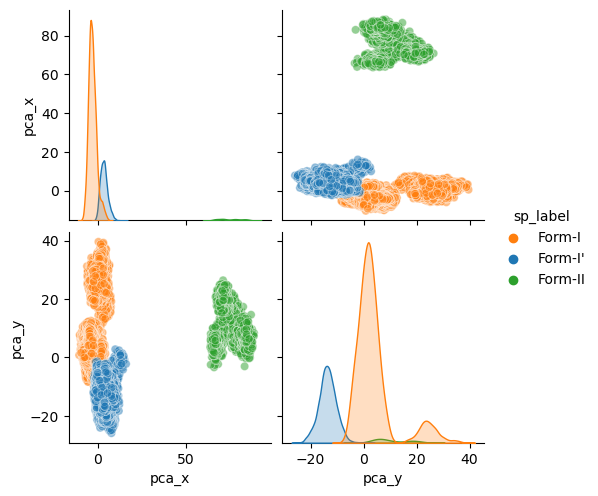

In [31]:
g = sns.pairplot(md_pca[['pca_x', 'pca_y', 'sp_label']], hue='sp_label', plot_kws={"alpha":0.5}, palette=['#ff7f0e', '#1f77b4', '#2ca02c'])
plt.savefig("./output/aligned_lsu_normalized_pca_Form_I_Ip_II_2_rep.svg")
plt.savefig("./output/aligned_lsu_normalized_pca_Form_I_Ip_II_2_rep.png", dpi=300, bbox_inches='tight')

In [ ]:
pc1_formI = md_pca[md_pca['subunit']]['pca_x']
pc1_formIp = md_pca[~md_pca['subunit']]['pca_x']